## ДЗ 6

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.
Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.
Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.
Задание 3: использовать permutation importance, выполнить задание 1 и 2.
Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.
Задание 5: использовать shap, выполнить задание 1 и 2.
Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

**Задание 0**: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [2]:
def categorical_str_to_freq(data: pd.DataFrame,
                        feature: str
                       ) -> pd.DataFrame:
    freq = data[feature].value_counts()
    data[feature] = data[feature].map(freq).astype('float')
    data[feature] = data[feature].fillna(0.0).astype('float')
    data[feature] = data[feature] / data.shape[0]
    
    return data

In [45]:
df_train = pd.read_csv(
    "../assignment2_data/df_train.csv",
    index_col=0
)

df_valid = pd.read_csv(
    "../assignment2_data/df_valid.csv",
    index_col=0
)

df_test = pd.read_csv(
    "../assignment2_data/df_test.csv",
    index_col=0
)

print("df_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

df_train.shape = 126000 rows, 431 cols
df_valid.shape = 54000 rows, 431 cols
df_test.shape = 100001 rows, 431 cols


In [46]:
y_train = df_train['isFraud']
y_valid = df_valid['isFraud']
y_test = df_test['isFraud']

df_train.drop(['isFraud'], axis='columns', inplace=True)
df_valid.drop(['isFraud'], axis='columns', inplace=True)
df_test.drop(['isFraud'], axis='columns', inplace=True)

In [47]:
numeric_feature = df_train.select_dtypes(include=[np.number]).columns
сategorical_feature = list(set(df_train.columns) - set(numeric_feature))

for cat in сategorical_feature:    
    df_train = categorical_str_to_freq(df_train, cat)
    df_valid = categorical_str_to_freq(df_valid, cat)
    df_test = categorical_str_to_freq(df_test, cat)

In [6]:
df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

In [7]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(data=df_train_d, label=y_train)
dvalid = xgb.DMatrix(data=df_valid_d, label=y_valid)
dtest = xgb.DMatrix(data=df_test_d)

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

[11:51:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65359	valid-auc:0.64252
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[100]	train-auc:0.91132	valid-auc:0.89934
Stopping. Best iteration:
[152]	train-auc:0.92081	valid-auc:0.90424



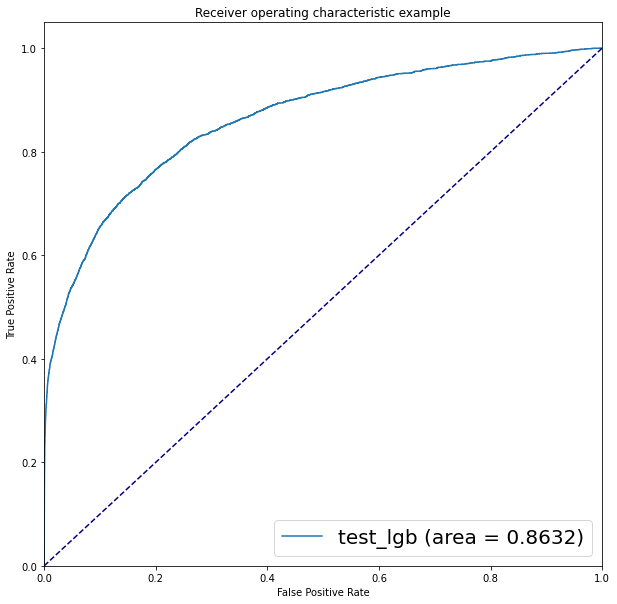

In [8]:
fig = plt.figure(figsize=(10, 10))
#------------------------------------------------------------------------------
#xgb
pred = model_xgb.predict(dtest)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

**Задание 1**: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

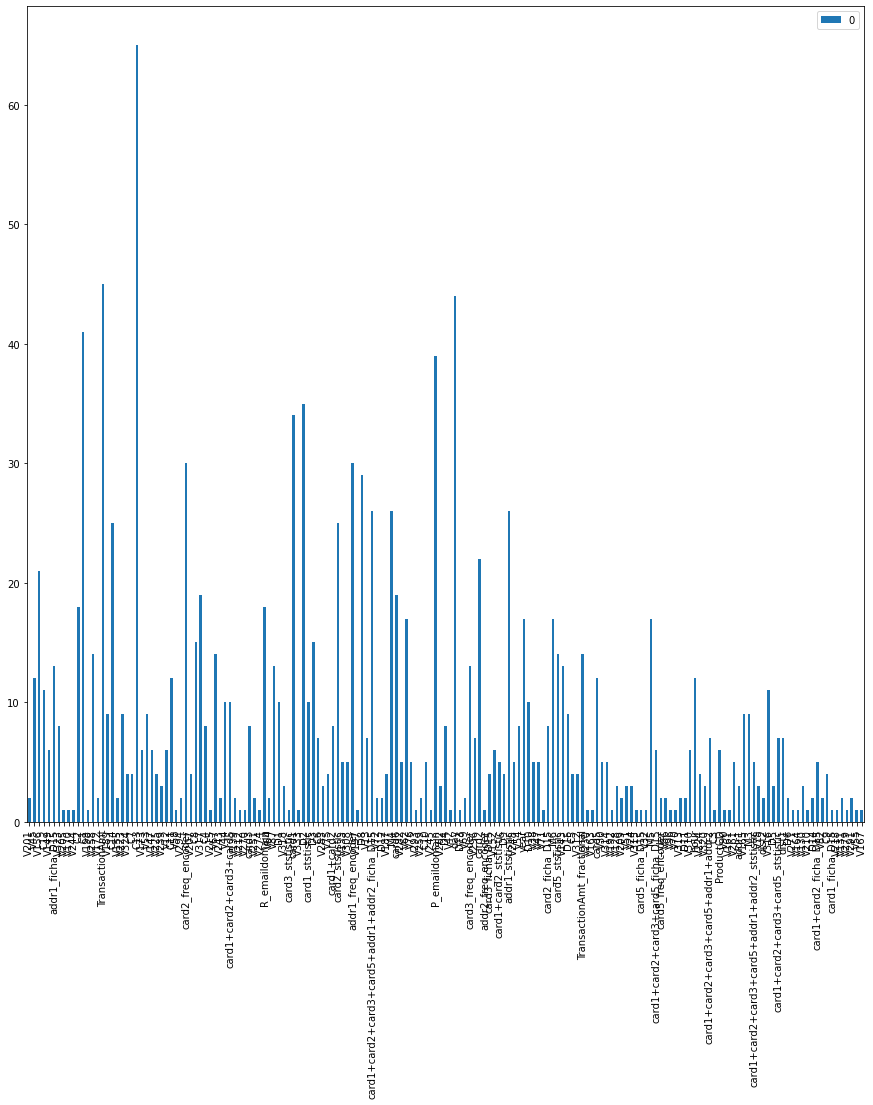

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

feature_importances = pd.DataFrame(model_xgb.get_score(), index=[0])
#feature_importances.loc[0] = model_xgb.feature_importances()
feature_importances.T.abs().plot(kind='bar')
plt.show()

**Задание 2**: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [10]:
feature_low_importance = feature_importances.loc[:, feature_importances.loc[0, :] < 10].columns
feature_high_importance = list(set(feature_importances.columns) - set(feature_low_importance))

Wall time: 0 ns
[11:52:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65863	valid-auc:0.65102
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[100]	train-auc:0.90713	valid-auc:0.89774
Stopping. Best iteration:
[157]	train-auc:0.91557	valid-auc:0.90161



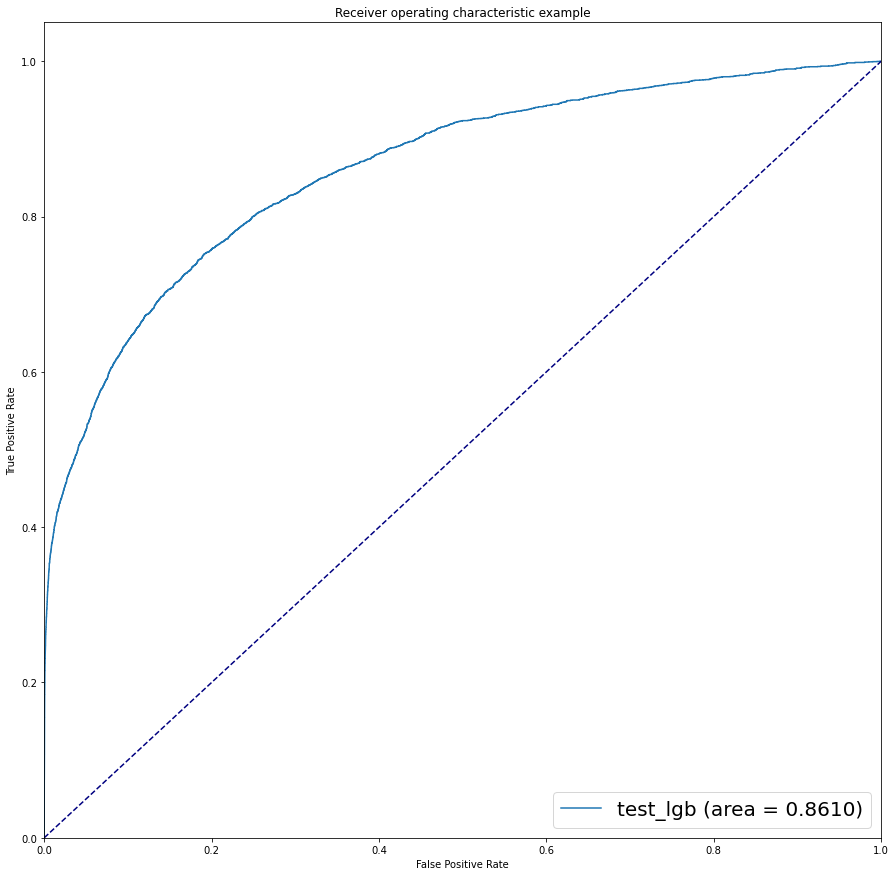

In [12]:
%%time

df_train_d = df_train[feature_high_importance].copy()
df_valid_d = df_valid[feature_high_importance].copy()
df_test_d = df_test[feature_high_importance].copy()

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(data=df_train_d, label=y_train)
dvalid = xgb.DMatrix(data=df_valid_d, label=y_valid)
dtest = xgb.DMatrix(data=df_test_d)

model_xgb_1 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

#------------------------------------------------------------------------------
#xgb
pred = model_xgb_1.predict(dtest)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

Качество модели незначительно снизилось с .904 до .901

**Задание 3**: использовать permutation importance, выполнить задание 1 и 2.

In [15]:
%%time

from sklearn.inspection import permutation_importance

xgb_params = deepcopy(params)
xgb_params["n_estimators"] = 100

df_train_d = df_train.copy()
df_valid_d = df_valid.copy()
df_test_d = df_test.copy()

model = xgb.XGBClassifier(**xgb_params)
model.fit(df_train_d, y_train)

importance = permutation_importance(
    model, df_valid_d, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

Wall time: 12min 41s


In [30]:
importance_scores = pd.DataFrame({
    "features": df_train.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)
raising_scores = importance_scores[importance_scores["importance-mean"]>0]

[13:48:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65358	valid-auc:0.64250
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[100]	train-auc:0.90905	valid-auc:0.89914
Stopping. Best iteration:
[144]	train-auc:0.91739	valid-auc:0.90410



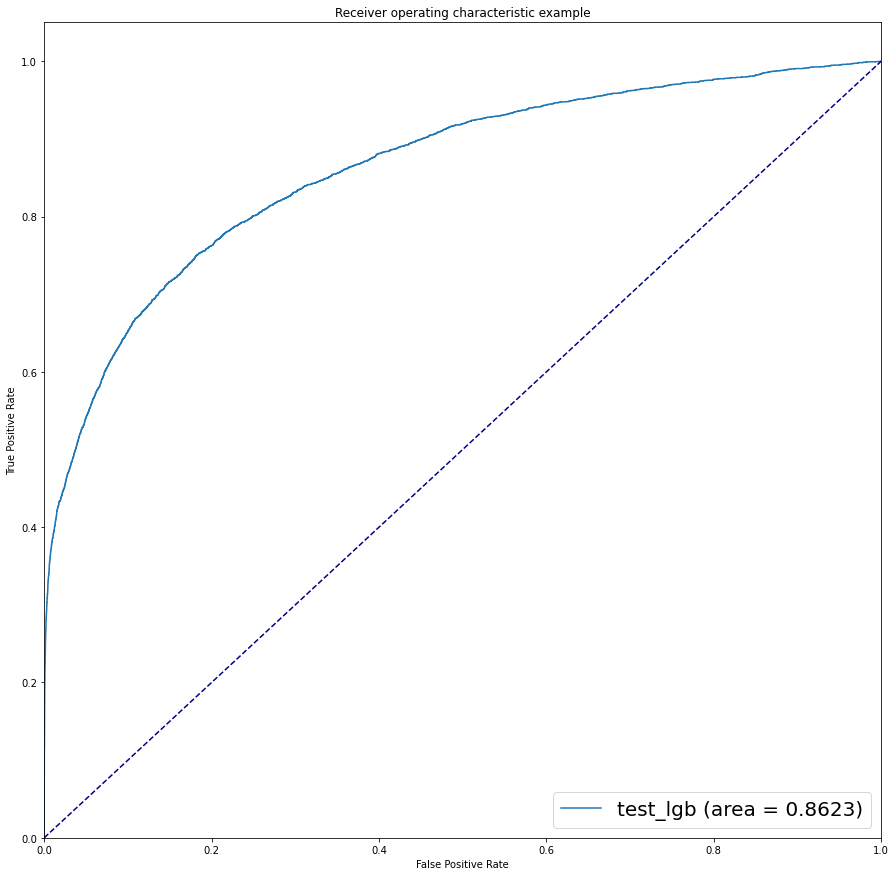

Wall time: 35.8 s


In [33]:
%%time

df_train_d = df_train[raising_scores['features'].values].copy()
df_valid_d = df_valid[raising_scores['features'].values].copy()
df_test_d = df_test[raising_scores['features'].values].copy()

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(data=df_train_d, label=y_train)
dvalid = xgb.DMatrix(data=df_valid_d, label=y_valid)
dtest = xgb.DMatrix(data=df_test_d)

model_xgb_2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

#------------------------------------------------------------------------------
#xgb
pred = model_xgb_2.predict(dtest)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

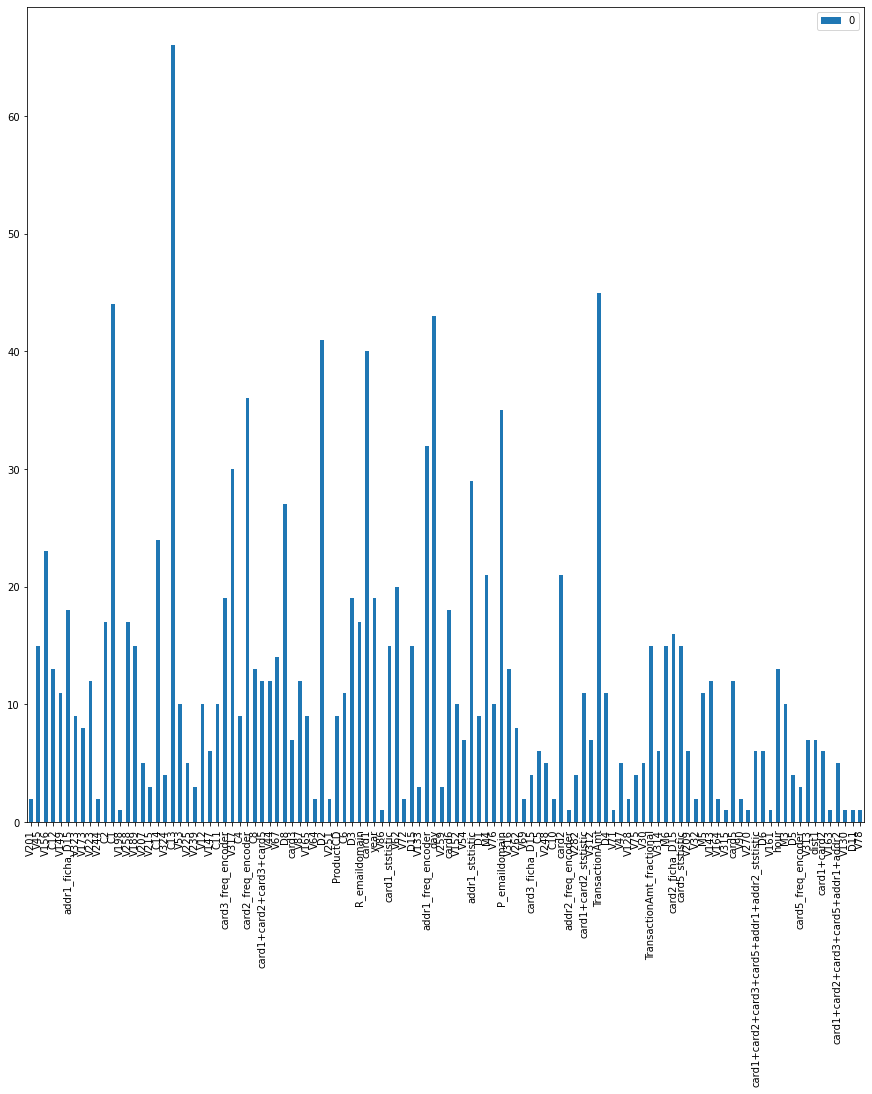

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

#feature_importances = pd.DataFrame(columns=df_train_d.columns)
feature_importances = pd.DataFrame(model_xgb_2.get_score(), index=[0])
#feature_importances.loc[0] = model_xgb.feature_importances()
feature_importances.T.abs().plot(kind='bar')
plt.show()

**Задание 4**: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

In [35]:
!pip install boostaroota
from boostaroota import BoostARoota

In [38]:
df_train['TransactionAmt_fractional'].value_counts()

0.000    73838
0.950    17472
0.950     5103
0.500     4312
0.950     3779
         ...  
0.288        1
0.322        1
0.626        1
0.051        1
0.026        1
Name: TransactionAmt_fractional, Length: 2257, dtype: int64

Применим этот метод к исходным данным без сгенерированных признаков 

In [48]:
df_train_dummie = pd.read_csv(
    "../assignment2_data/assignment_2_train.csv"
)

df_test_dummie = pd.read_csv(
    "../assignment2_data/assignment_2_test.csv"
)

df_train_dummie.drop(['TransactionDT', 'TransactionID'], axis='columns', inplace=True)
df_test_dummie.drop(['TransactionDT', 'TransactionID'], axis='columns', inplace=True)

print("df_train_dummie.shape = {} rows, {} cols".format(*df_train_dummie.shape))
#print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test_dummie.shape = {} rows, {} cols".format(*df_test_dummie.shape))

numeric_feature = df_train_dummie.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_train_dummie.columns) - set(numeric_feature))

for i in range(len(сategorical_feature)):
    print(f'feature {сategorical_feature[i]}')
    сategorical_train = df_train_dummie[сategorical_feature[i]].unique()
    сategorical_test = df_test_dummie[сategorical_feature[i]].unique()
    
    cat_in_feature = list(set(сategorical_train) & set(сategorical_test))
    for cat in cat_in_feature:
        dummie_feature_name = f'{сategorical_feature[i]}_{cat}'
        #print(dummie_feature_name)
        
        if str(cat) != 'nan':
            print(f'    dummie feature name: {dummie_feature_name}')
            df_train_dummie[f'{сategorical_feature[i]}_{cat}'] = 0
            df_train_dummie.loc[df_train_dummie.loc[:,сategorical_feature[i]]==cat, 
                                                          [dummie_feature_name]] = 1      
                        
            df_test_dummie[f'{сategorical_feature[i]}_{cat}'] = 0
            df_test_dummie.loc[df_test_dummie.loc[:,сategorical_feature[i]]==cat, 
                                                          [dummie_feature_name]] = 1 
            
    df_train_dummie.drop([сategorical_feature[i]], axis='columns', inplace=True)
    df_test_dummie.drop([сategorical_feature[i]], axis='columns', inplace=True)
    
print("df_train_dummie.shape = {} rows, {} cols".format(*df_train_dummie.shape))
print("df_test_dummie.shape = {} rows, {} cols".format(*df_test_dummie.shape))

df_train_dummie, df_valid_dummie = train_test_split(df_train_dummie, test_size=0.3,  random_state=42)
print("df_train_dummie.shape = {} rows, {} cols".format(*df_train_dummie.shape))
print("df_valid_dummie.shape = {} rows, {} cols".format(*df_valid_dummie.shape))
print("df_test_dummie.shape = {} rows, {} cols".format(*df_test_dummie.shape))

y_train_dummie = df_train_dummie['isFraud']
y_valid_dummie = df_valid_dummie['isFraud']
y_test_dummie = df_test_dummie['isFraud']

df_train_dummie.drop(['isFraud'], axis='columns', inplace=True)
df_valid_dummie.drop(['isFraud'], axis='columns', inplace=True)
df_test_dummie.drop(['isFraud'], axis='columns', inplace=True)

print("df_train_dummie.shape = {} rows, {} cols".format(*df_train_dummie.shape))
print("df_valid_dummie.shape = {} rows, {} cols".format(*df_valid_dummie.shape))
print("df_test_dummie.shape = {} rows, {} cols".format(*df_test_dummie.shape))

df_train_dummie.shape = 180000 rows, 392 cols
df_test_dummie.shape = 100001 rows, 392 cols
feature P_emaildomain
    dummie feature name: P_emaildomain_servicios-ta.com
    dummie feature name: P_emaildomain_juno.com
    dummie feature name: P_emaildomain_suddenlink.net
    dummie feature name: P_emaildomain_att.net
    dummie feature name: P_emaildomain_aim.com
    dummie feature name: P_emaildomain_yahoo.com
    dummie feature name: P_emaildomain_cox.net
    dummie feature name: P_emaildomain_frontiernet.net
    dummie feature name: P_emaildomain_cfl.rr.com
    dummie feature name: P_emaildomain_embarqmail.com
    dummie feature name: P_emaildomain_charter.net
    dummie feature name: P_emaildomain_outlook.com
    dummie feature name: P_emaildomain_prodigy.net.mx
    dummie feature name: P_emaildomain_icloud.com
    dummie feature name: P_emaildomain_live.com.mx
    dummie feature name: P_emaildomain_mail.com
    dummie feature name: P_emaildomain_yahoo.com.mx
    dummie feature name

[15:26:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65359	valid-auc:0.64252
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[100]	train-auc:0.90245	valid-auc:0.89226
Stopping. Best iteration:
[142]	train-auc:0.90995	valid-auc:0.89831



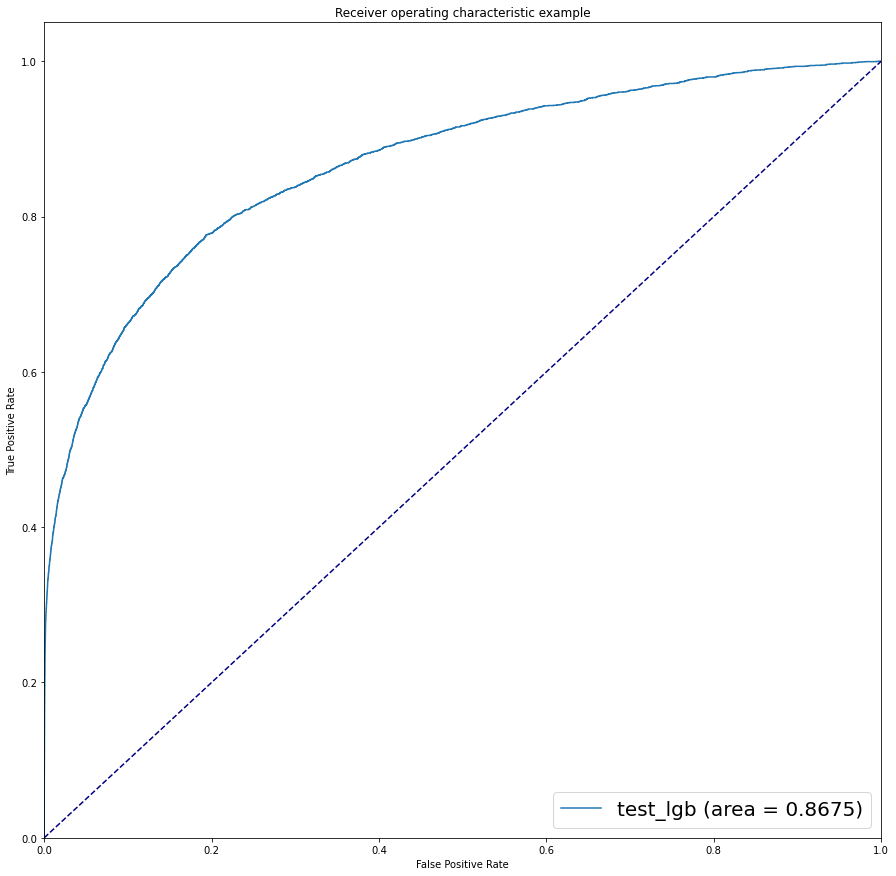

Wall time: 1min 59s


In [49]:
%%time

df_train_d = df_train_dummie.copy()
df_valid_d = df_valid_dummie.copy()
df_test_d = df_test_dummie.copy()

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(data=df_train_d, label=y_train_dummie)
dvalid = xgb.DMatrix(data=df_valid_d, label=y_valid_dummie)
dtest = xgb.DMatrix(data=df_test_d)

model_xgb_3 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

#------------------------------------------------------------------------------
#xgb
pred = model_xgb_3.predict(dtest)
fpr, tpr, _ = roc_curve(y_test_dummie, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [50]:
import warnings
warnings.filterwarnings('ignore')

br = BoostARoota(metric='auc')
br.fit(df_train_dummie, y_train_dummie)

[15:33:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[15:34:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[15:34:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to som

In [51]:
br.keep_vars_

0                   TransactionAmt
1                            card1
2                            card2
3                            card3
4                            card5
                  ...             
261    R_emaildomain_anonymous.com
263        R_emaildomain_gmail.com
264                           M2_F
265                    ProductCD_H
266                    ProductCD_R
Name: feature, Length: 241, dtype: object

[15:39:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65359	valid-auc:0.64252
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[100]	train-auc:0.90245	valid-auc:0.89226
Stopping. Best iteration:
[142]	train-auc:0.90995	valid-auc:0.89831



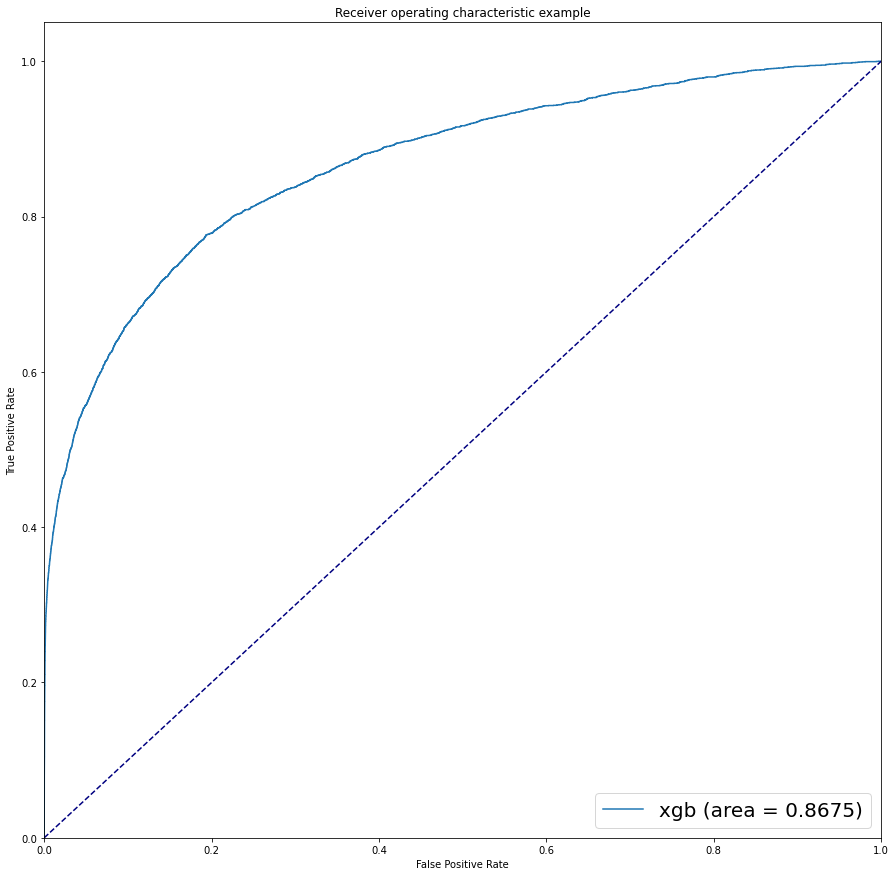

In [52]:
x_train_br = br.transform(df_train_d)
x_valid_br = br.transform(df_valid_d)
x_test_br = br.transform(df_test_d)

dtrain_br = xgb.DMatrix(x_train_br, label=y_train_dummie)
dvalid_br = xgb.DMatrix(x_valid_br, label=y_valid_dummie)
dtest_br = xgb.DMatrix(data=x_test_br)

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model_xgb_br = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

#------------------------------------------------------------------------------
#xgb
pred = model_xgb_br.predict(dtest)
fpr, tpr, _ = roc_curve(y_test_dummie, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [53]:
print("x_train_br.shape = {} rows, {} cols".format(*x_train_br.shape))
print("x_valid_br.shape = {} rows, {} cols".format(*x_valid_br.shape))
print("x_test_br.shape = {} rows, {} cols".format(*x_test_br.shape))

x_train_br.shape = 126000 rows, 241 cols
x_valid_br.shape = 54000 rows, 241 cols
x_test_br.shape = 100001 rows, 241 cols


Количество переменных сократилось, а точность незначительно упала.

**Задание 5**: использовать shap, выполнить задание 1 и 2.

In [59]:
!pip install shap
import shap

In [62]:
df_valid = pd.read_csv(
    "../assignment2_data/df_valid.csv",
    index_col=0
)

numeric_feature = df_valid.select_dtypes(include=[np.number]).columns
сategorical_feature = list(set(df_valid.columns) - set(numeric_feature))

for cat in сategorical_feature:    
    df_valid = categorical_str_to_freq(df_valid, cat)

x_valid_ = df_valid.sample(2000)
y_valid_ =  x_valid_['isFraud']
x_valid_.drop(['isFraud'], axis='columns', inplace=True)

y_valid = df_valid['isFraud']
df_valid.drop(['isFraud'], axis='columns', inplace=True)

In [63]:
explainer = shap.TreeExplainer(model_xgb) #Это есчи что самая первая модель
shap_values = explainer.shap_values(x_valid_, y_valid_)

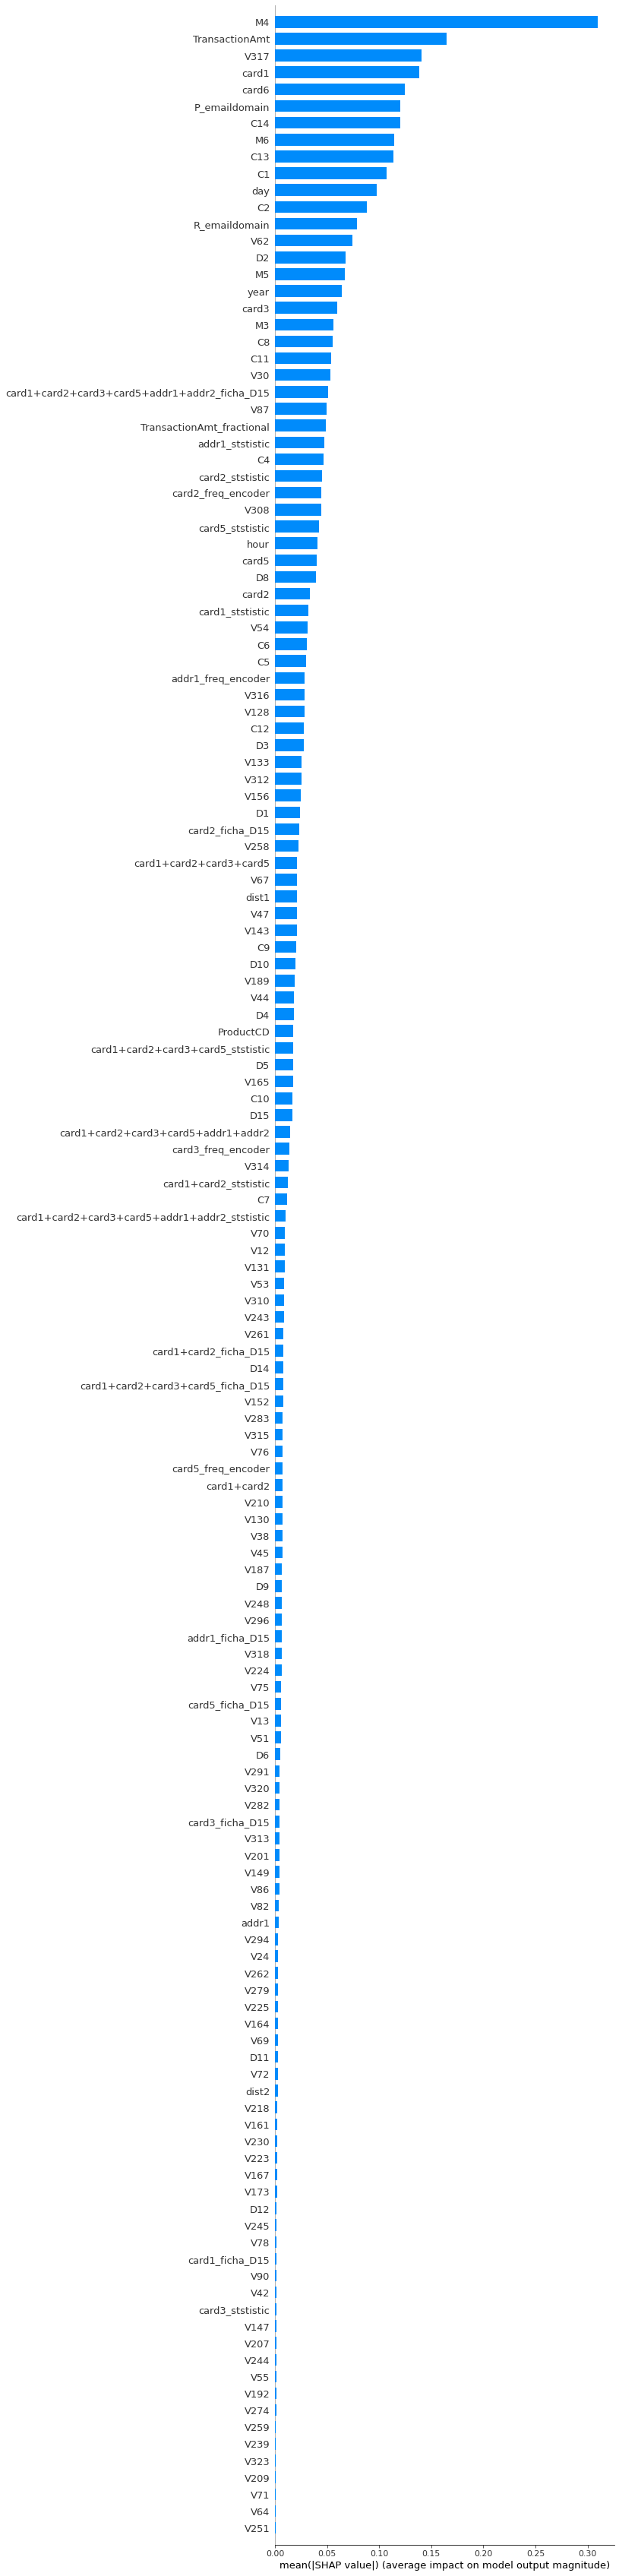

In [120]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=150)

In [132]:
shap_values.shape

(2000, 430)

In [180]:
mean = list()

for j in range(shap_values.shape[1]):
    bufer = 0
    for i in range(shap_values.shape[0]):
        bufer += np.abs(shap_values[i][j])
    bufer /= shap_values.shape[0]
    mean.append(bufer)

mean = np.array(mean).reshape(-1, shap_values.shape[1])
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [233]:
feature_importances = pd.DataFrame(mean, columns=x_valid_.columns, index=['importances'])
feature_importances = feature_importances.sort_values('importances', axis=1, ascending=0)
max_num_feature = feature_importances.loc['importances', feature_importances.loc['importances',:]>0].shape[0]
feature_high_importances = feature_importances.iloc[0:max_num_feature].columns
feature_high_importances

Index(['M4', 'TransactionAmt', 'V317', 'card1', 'card6', 'P_emaildomain',
       'C14', 'M6', 'C13', 'C1',
       ...
       'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V46', 'V188', 'V43',
       'TransactionAmt_log'],
      dtype='object', length=430)

[17:30:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65359	valid-auc:0.64252
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[100]	train-auc:0.91132	valid-auc:0.89934
Stopping. Best iteration:
[152]	train-auc:0.92081	valid-auc:0.90424



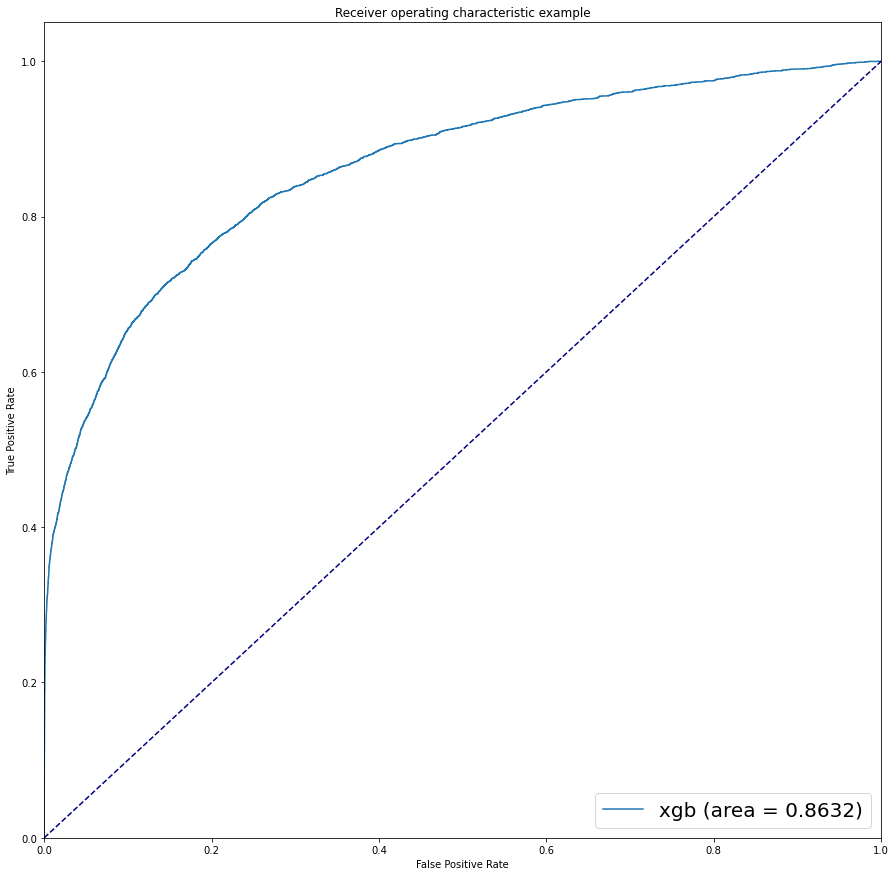

Wall time: 1min 50s


In [235]:
%%time

df_train_d = df_train[feature_high_importances].copy()
df_valid_d = df_valid[feature_high_importances].copy()
df_test_d = df_test[feature_high_importances].copy()

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(data=df_train_d, label=y_train)
dvalid = xgb.DMatrix(data=df_valid_d, label=y_valid)
dtest = xgb.DMatrix(data=df_test_d)

model_xgb_5 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

#------------------------------------------------------------------------------
#xgb
pred = model_xgb_5.predict(dtest)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

Модель значительно облегчили, но точнее базовой не стало.

**Задание 6**: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

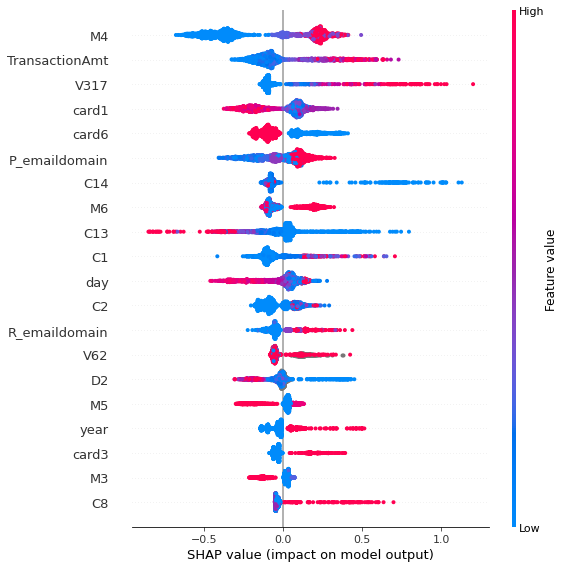

In [73]:
shap.summary_plot(shap_values, x_valid_, )

При увеличении М4  растет и шанс положительго значения целевой переменной (за исключение небольшого кол-ва данных.

Также и при TransactionAmt, V317, чем больше, те выше шанс. 

card6 четко разделяет.

С14 бесполезный признак, и странно, что он в топе.

Очень подозрительно с year.

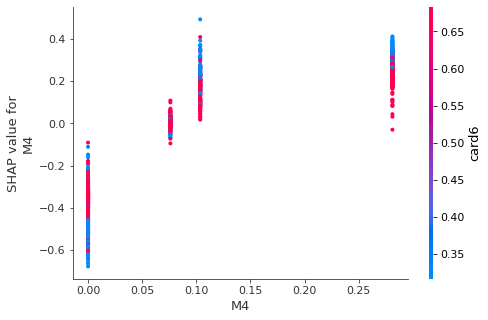

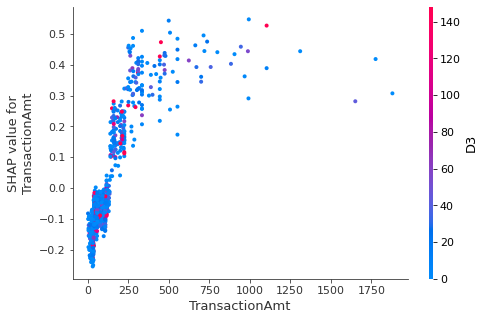

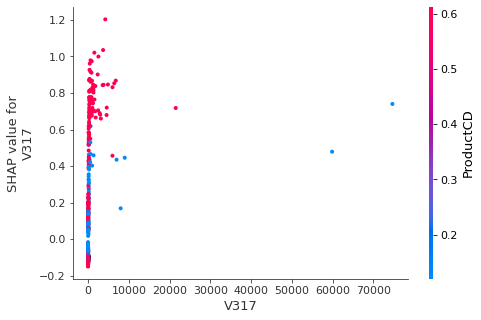

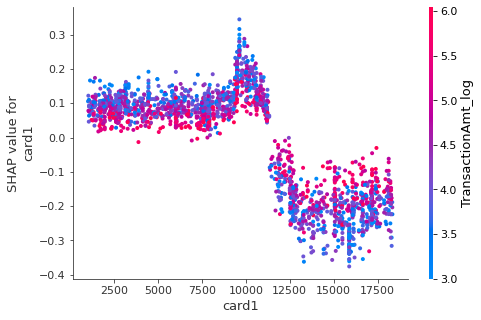

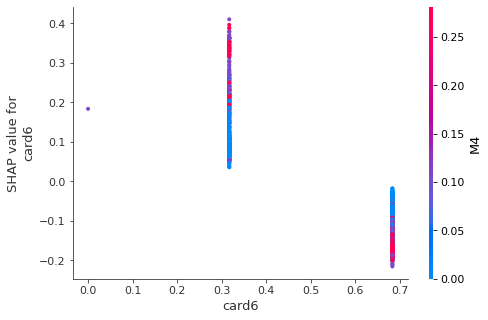

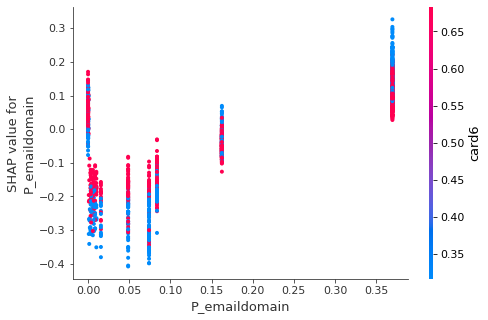

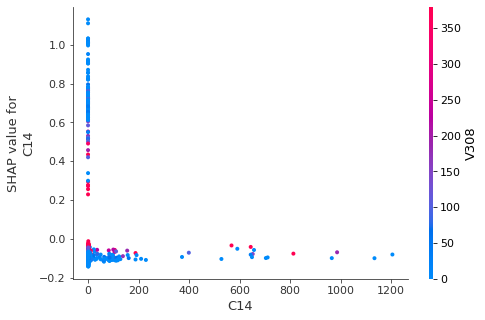

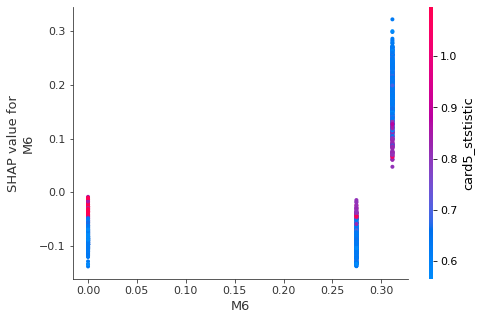

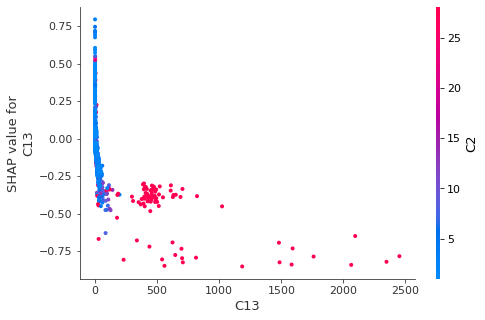

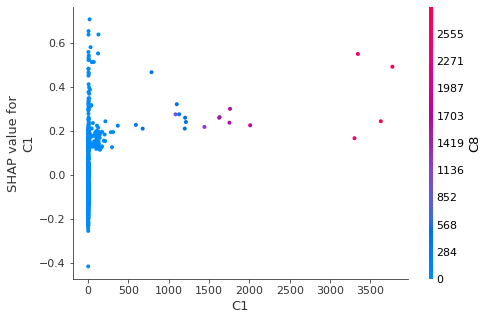

In [236]:
dependence_features = feature_high_importances[:10]
for name in dependence_features:
    shap.dependence_plot(name, shap_values, x_valid_, display_features=x_valid_)

Много выбросов на самых значимых признаках.

In [251]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

n = 350
select = 20
#select = range(200)
features = df_valid.iloc[n:n+select]
features_display = df_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-3.7053799]


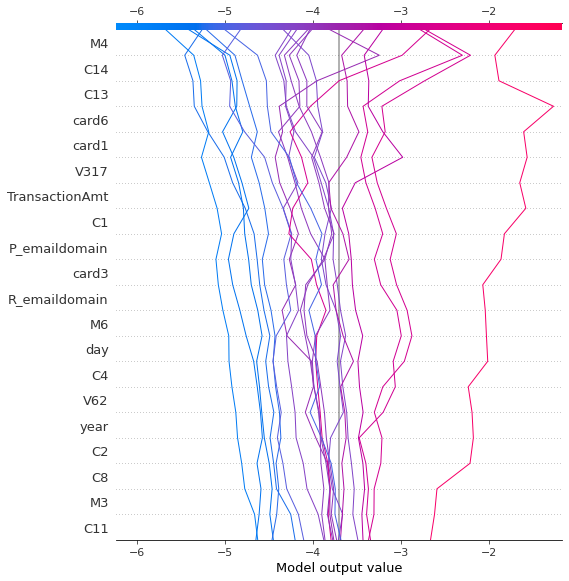

In [252]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:40]
)